# Importing Data

In [65]:
import pandas as pd
import censusgeocode as cg 
df = pd.read_csv("green_data/kc_house_data.csv")


# Data Cleaning

In [66]:
#drop rows with null values
df.dropna(subset = ['heat_source', 'sewer_system'], inplace = True)

In [67]:
#change date to datetime and split out sale year and month
df['date'] = pd.to_datetime(df['date'])
df['sale_month'] = df['date'].dt.month.astype(int)
df['sale_year'] = df['date'].dt.year.astype(int)

In [68]:
#drop rows containing addresses not in King County
        
zip_list = [98052,98115,98103,98092,98042,98023,98105,98003,98034,98118,98133,98058,98125,98031,98122,98033,98006,98032,98030,98004,98001,98059,98117,98056,98198,98168,98155,98027,98109,98002,98038,98144,98146,98074,98119,98007,98040,98029,98107,98011,98108,98072,98106,98178,98116,98112,98008,98053,98028,98126,98188,98102,98055,98075,98177,98022,98166,98199,98005,98121,98136,98045,98057,98019,98104,98077,98101,98065,98148,98070,98014,98354,98024,98051,98010,98047,98251,98134,98039,98195,98158,98068,98256,98288,98050,98132,98171,98184,98054,98009,98013,98015,98025,98035,98041,98062,98064,98063,98071,98073,98083,98089,98093,98111,98113,98114,98124,98127,98131,98129,98139,98138,98141,98145,98151,98154,98160,98164,98161,98165,98170,98174,98175,98181,98185,98190,98194,98191,98224,98471,98481]
zip_list = list(map(lambda x: str(x), zip_list))

df['in_target_area'] = df['address'].apply(lambda x: any(zip_code in x for zip_code in zip_list))
df = df.drop(df[df['in_target_area'] == False].index)

In [69]:
# Breakout city and zipcode from the address column

def residential_check(value):
    if len(value.split(',')) == 4:
        return True
    if len(value.split(',')) != 4:
        return False

df['residential'] = df['address'].apply(lambda x: residential_check(x))    
df = df.drop(df[df['residential'] == False].index)
df[['House_Num', 'City', 'State_ZIP', 'Country']] = df['address'].str.split(',', expand=True)    
df[['Empty', 'State', 'ZIP']] = df['State_ZIP'].str.split(' ', expand=True) 
df.drop(columns = ['Empty', 'in_target_area', 'residential'], inplace = True)


In [70]:
# Drop all duplicated housing IDs and addresses. Drop homes missing bed/bath data
df['id'].duplicated().value_counts()
df.drop_duplicates(subset = 'id', keep = 'first', inplace = True)


df['address'].duplicated().value_counts() 
df.sort_values(by = ['date'], ascending = False, inplace = True)
df.drop_duplicates(subset = ['address'], keep = 'first', inplace = True)

df = df[(df['bedrooms'] != 0) & (df['bathrooms'] != 0)]


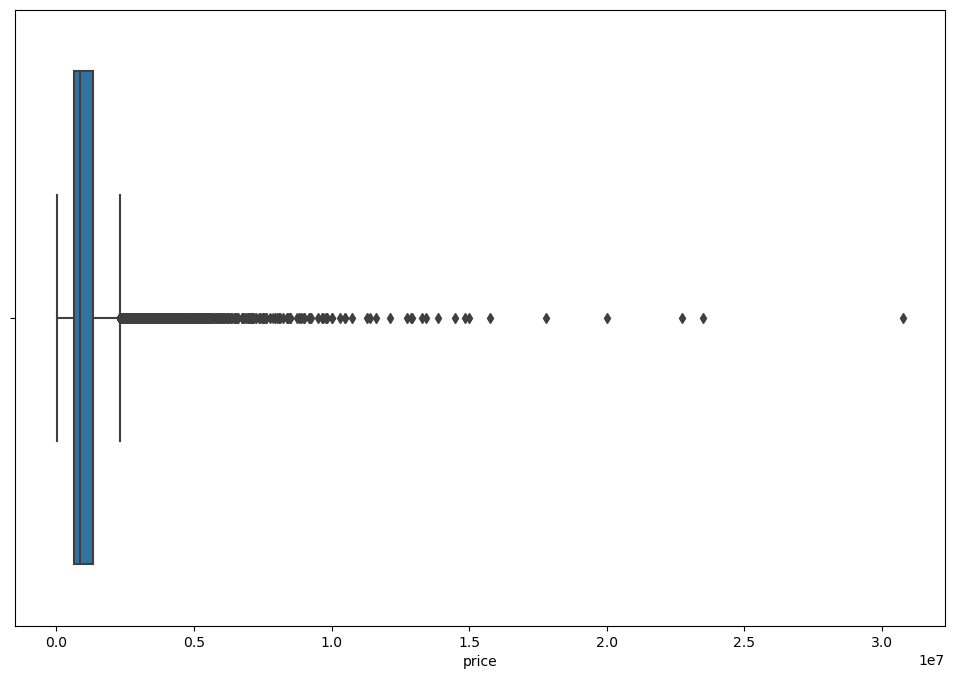

In [71]:
#Visualize price to find outliers 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x = df['price'])
plt.show()

In [72]:
#Changing "Washington" tp "WA"
df["State"] = "WA"



# Creating Base Model

/var/folders/cv/wb903gfd5v1dl5wd51qpkw480000gn/T/ipykernel_77074/2621729593.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


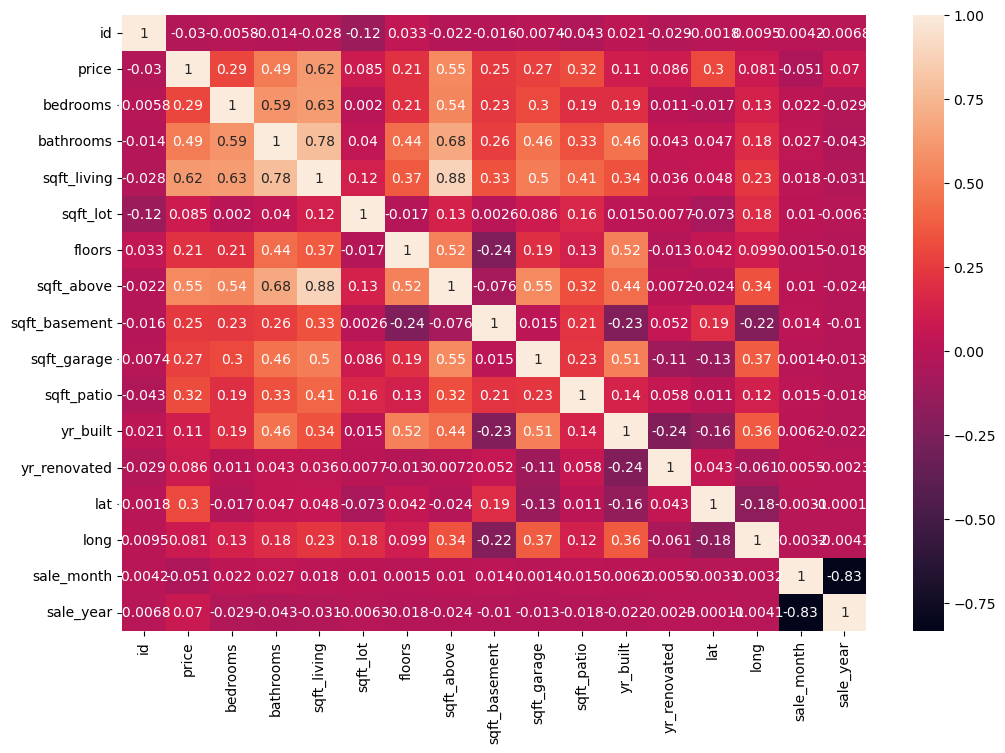

In [73]:
#Run heatmap to identify variables most correlated with price 
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot = True)
plt.show();

# sqft_living most correlated with price, use as single variable base model

In [74]:
# Run train-test split to create test and control group

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
import numpy as np

X = df['sqft_living'].values.reshape(-1,1)
y = df['price'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

#baseline r-squared value is .3422 

0.3422830933088098

# Model 1: Multi-Linear using select numeric columns and standard scalar

In [75]:
numeric_df = df.select_dtypes(exclude=['object', 'datetime'])

X = numeric_df.drop(columns=['price', 'lat', 'long', 'id'])
y = numeric_df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
model.score(X_test_scaled, y_test)
dict(zip(X_train.columns, model.coef_))

{'bedrooms': -158497.105188241,
 'bathrooms': 124780.75324626395,
 'sqft_living': 324730.34022166434,
 'sqft_lot': -6643.678985736625,
 'floors': -21592.17149214731,
 'sqft_above': 288256.01893072575,
 'sqft_basement': 100417.10771529553,
 'sqft_garage': -39851.45782790976,
 'sqft_patio': 58295.62552812415,
 'yr_built': -107553.0180028062,
 'yr_renovated': 24896.265059943882,
 'sale_month': 37796.092008746935,
 'sale_year': 109634.44212145598}

In [76]:
numeric_df = df.select_dtypes(exclude=['object', 'datetime'])

X = numeric_df.drop(columns=['price', 'lat', 'long', 'id'])
y = numeric_df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

import statsmodels.api as sm
model_OLS = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_scaled)).fit()
model_OLS.summary()


# dubin watson is close to 2, which means that our errors are independent


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     1258.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:28:40   Log-Likelihood:            -2.8755e+05
No. Observations:               19410   AIC:                         5.751e+05
Df Residuals:                   19396   BIC:                         5.752e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.117e+06   4717.411    236.831      0.000    1.11e+06    1.13e+06
x1         -1.585e+05   6347.911    -24.968      0.000   -1.71e+05   -1.46e+05
x2          1.248e+05   8721.529     14.307      0.000    1.08e+05    1.42e+05
x3          3.247e+05   2.12e+04     15.346      0.000    2.83e+05    3.66e+05
x4         -6643.6790   4841.288     -1.372      0.170   -1.61e+04    2845.663
x5         -2.159e+04   6541.020     -3.301      0.001   -3.44e+04   -8771.208
x6          2.883e+05   1.94e+04     14.870      0.000     2.5e+05    3.26e+05
x7          1.004e+05   9510.341     10.559      0.000    8.18e+04    1.19e+05
x8         -3.985e+04   6487.126     -6.143      0.000   -5.26e+04   -2.71e+04
x9           5.83e+04   5251.288     11.101      0.000     4.8e+04    6.86e+04
x10        -1.076e+05   7029.612    -15.300      0.000   -1.21e+05   -9.38e+04
x11          2.49e+04   4980.983      4.998      0.000    1.51e+04    3.47e+04
x12          3.78e+04   8559.557      4.416      0.000     2.1e+04    5.46e+04
x13         1.096e+05   8563.605     12.802      0.000    9.28e+04    1.26e+05
==============================================================================
Omnibus:                    24109.597   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11759376.129
Skew:                           6.316   Prob(JB):                         0.00
Kurtosis:                     122.919   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

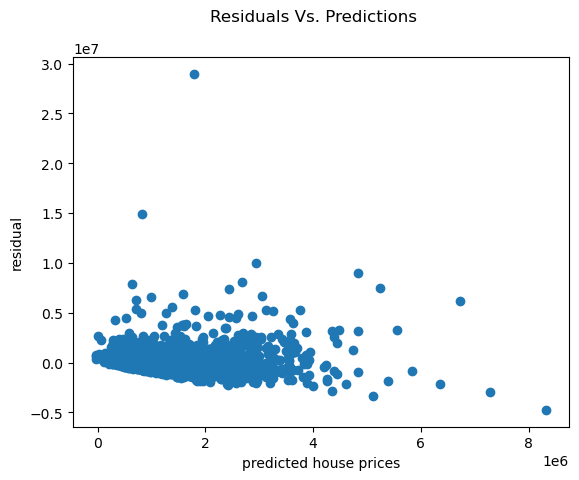

In [77]:
#Checking for linearity #1
model_preds = model.predict(X_test_scaled)

resids = y_test - model_preds

fig, ax = plt.subplots()

ax.scatter(model_preds, resids)
ax.set_xlabel('predicted house prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');


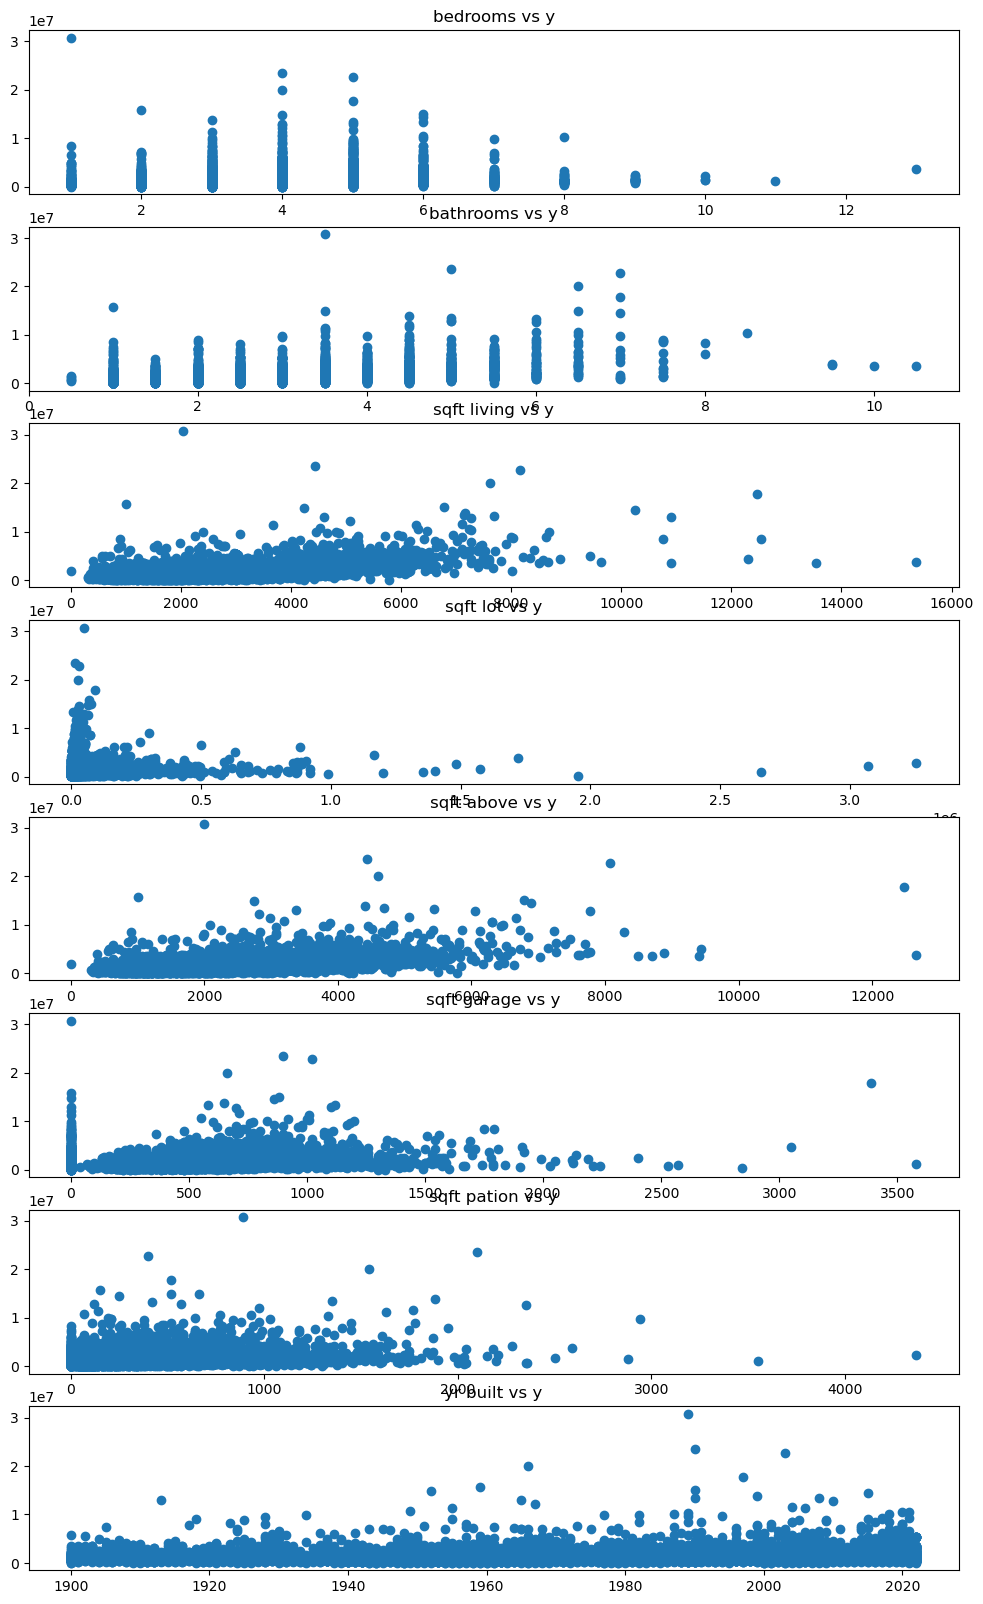

In [78]:
#Checking for linearity #2
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8, ncols=1, figsize=(12, 20))

ax1.scatter(X['bedrooms'], y)
ax1.set_title('bedrooms vs y')
ax2.scatter(X['bathrooms'], y)
ax2.set_title('bathrooms vs y')
ax3.scatter(X['sqft_living'], y)
ax3.set_title('sqft living vs y')
ax4.scatter(X['sqft_lot'], y)
ax4.set_title('sqft lot vs y')
ax5.scatter(X['sqft_above'], y)
ax5.set_title('sqft above vs y')
ax6.scatter(X['sqft_garage'], y)
ax6.set_title('sqft garage vs y')
ax7.scatter(X['sqft_patio'], y)
ax7.set_title('sqft pation vs y')
ax8.scatter(X['yr_built'], y)
ax8.set_title('yr built vs y');


# Importing Environment Data

In [79]:
lead_df = pd.read_csv("environment_data/census_data/Lead_Risk_from_Housing(2010_census).csv")
lead_king_df = lead_df.loc[(lead_df["County Name"] == "King"), ["Census Tract", "% Units w/ Lead Hazard (Estimated)"]]
lead_king_df


,Census Tract,% Units w/ Lead Hazard (Estimated)
296,53033000100,10.24
297,53033000200,20.11
298,53033000300,25.27
299,53033000401,9.47
300,53033000402,19.95
...,...,...
688,53033032602,2.71
689,53033032702,6.57
690,53033032703,33.52
691,53033032704,10.22


In [80]:
traffic_df = pd.read_csv("environment_data/census_data/Proximity_to_Heavy_Traffic_Roadways (2010_census).csv")
traffic_king_df = traffic_df.loc[traffic_df["County Name"] == "King", ["Census Tract", "Proximity to Heavy Traffic Roadways"]]
traffic_king_df1 = traffic_king_df.drop(traffic_king_df.index[-1])
traffic_king_df1

,Census Tract,Proximity to Heavy Traffic Roadways
302,53033000100,106265.93
303,53033000200,215000.00
304,53033000300,215000.00
305,53033000401,140603.44
306,53033000402,173851.70
...,...,...
694,53033032602,67000.00
695,53033032702,67000.00
696,53033032703,65000.00
697,53033032704,49000.00


In [81]:
superfund_df = pd.read_csv("environment_data/census_data/Proximity_to_National_Priorities_List_Facilities(superfund)(2021_census).csv")
superfund_king_df = superfund_df.loc[superfund_df["County Name"] == "King", ["Census Tract", "Average PNPL"]]
superfund_king_df


,Census Tract,Average PNPL
300,53033000100,0.06
301,53033000200,0.06
302,53033000300,0.06
303,53033000401,0.06
304,53033000402,0.07
...,...,...
692,53033032602,0.06
693,53033032702,0.05
694,53033032703,0.05
695,53033032704,0.05


In [82]:
toxic_df = pd.read_csv("environment_data/census_data/Toxic_Releases_from_Facilities_(RSEI_Model)(2010_census).csv")
toxic_king_df = toxic_df.loc[toxic_df["County Name"] == "King", ["Census Tract", "Average RSEI Concentrations"]]
toxic_king_df1 = toxic_king_df.drop(toxic_king_df.index[-1])
toxic_king_df1

,Census Tract,Average RSEI Concentrations
299,53033000100,4447.00
300,53033000200,7088.62
301,53033000300,2410.15
302,53033000401,4036.39
303,53033000402,3909.42
...,...,...
691,53033032602,3191.08
692,53033032702,1271.05
693,53033032703,297.25
694,53033032704,943.36


In [83]:
smoke_df = pd.read_csv("environment_data/census_data/Wildfire_Smoke_(2010_census).csv")
smoke_king_df = smoke_df.loc[smoke_df["County Name"] == "King", ["Census Tract", "Smoke Days"]]
smoke_king_df

,Census Tract,Smoke Days
302,53033000100,6.29
303,53033000200,6.14
304,53033000300,6.14
305,53033000401,6.14
306,53033000402,6.14
...,...,...
694,53033032602,6.43
695,53033032702,6.86
696,53033032703,6.43
697,53033032704,6.29


In [84]:
environment_merge = pd.merge(lead_king_df, traffic_king_df1, on = "Census Tract")
environment_merge = pd.merge(environment_merge, superfund_king_df, on = "Census Tract")
environment_merge = pd.merge(environment_merge, toxic_king_df1, on = "Census Tract")
environment_merge = pd.merge(environment_merge, smoke_king_df, on = "Census Tract")
environment_merge

,Census Tract,% Units w/ Lead Hazard (Estimated),Proximity to Heavy Traffic Roadways,Average PNPL,Average RSEI Concentrations,Smoke Days
0,53033000100,10.24,106265.93,0.06,4447.00,6.29
1,53033000200,20.11,215000.00,0.06,7088.62,6.14
2,53033000300,25.27,215000.00,0.06,2410.15,6.14
3,53033000401,9.47,140603.44,0.06,4036.39,6.14
4,53033000402,19.95,173851.70,0.07,3909.42,6.14
...,...,...,...,...,...,...
392,53033032602,2.71,67000.00,0.06,3191.08,6.43
393,53033032702,6.57,67000.00,0.05,1271.05,6.86
394,53033032703,33.52,65000.00,0.05,297.25,6.43
395,53033032704,10.22,49000.00,0.05,943.36,6.29


In [85]:
GEO_ID = cg.address('11231 Greenwood Avenue North', city='Seattle', state='WA', zip='98133')[0]["geographies"]['Census Tracts'][0]["GEOID"]
GEO_ID

'53033001400'

In [86]:
GEO_ID = cg.address('4673 Eastern Avenue North', city='Seattle', state='WA', zip='98103')[0]["geographies"]['Census Tracts'][0]["GEOID"]
GEO_ID

'53033005100'

In [87]:
GEO_ID = cg.address('24715 232nd Place Southeast', city='Maple Valley', state='WA', zip='98038')[0]["geographies"]['Census Tracts'][0]["GEOID"]
GEO_ID

'53033032010'

In [88]:
GEO_ID = cg.address('14248 77th Avenue Northeast', city='Kirkland', state='WA', zip='98034')[0]["geographies"]['Census Tracts'][0]["GEOID"]
GEO_ID

'53033022201'

In [90]:
df["City"].value_counts()

 Seattle                    9207
 Renton                     1943
 Kent                       1582
 Auburn                     1508
 Bellevue                   1480
 Kirkland                   1269
 Federal Way                1165
 Redmond                     985
 Sammamish                   975
 Maple Valley                885
 Shoreline                   795
 Burien                      614
 Woodinville                 578
 Issaquah                    563
 Covington                   501
 North Bend                  464
 Enumclaw                    455
 Des Moines                  423
 Mercer Island               348
 Kenmore                     345
 Snoqualmie                  289
 Black Diamond               276
 Bothell                     261
 SeaTac                      252
 Duvall                      245
 Lake Forest Park            217
 Vashon                      189
 Newcastle                   187
 Tukwila                     178
 Carnation                   157
 Normandy 

In [97]:
df["City"] = df["City"].apply(lambda x: x.strip())
df["ZIP"] = df["ZIP"].apply(lambda x: x.strip())
df["House_Num"] = df["House_Num"].apply(lambda x: x.strip())


In [96]:
GEO_ID = cg.address('15319 SE 178th St', city='Fairwood', state='WA', zip='98058')[0]["geographies"]['Census Tracts'][0]["GEOID"]
GEO_ID

'53033031908'

In [98]:
df["Census Tract"] = df.apply(lambda row: cg.address(row["House_Num"], city = row["City"], state = row["State"], zip = row["ZIP"])[0]["geographies"]['Census Tracts'][0]["GEOID"], axis = 1)


IndexError: list index out of range

# EDA

# Train/Test/Split

# Training

# Test

# Check Assumptions